In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
from time import time
from projection_utils import *
from data_pipeline import *
from models import *
from pose_depth_estimation import *

In [2]:
# load the 3d-box points of objects, scene in image
scene = 'scene0029_00'
path = os.path.join('scannet/scans',scene,'pose')
BASE_DIR= os.path.dirname(path)
poses=os.listdir(path)

box_path = os.path.join(BASE_DIR, 'box_coords.txt')

if os.path.exists(box_path):
    box_points= np.loadtxt(box_path)
else:
    box_path = 'scannet/votenet_files/scannet_train_detection_data/'
    box_points= np.loadtxt(os.path.join(box_path,scene,'box_coords.txt'))

ply_file=os.path.join('scannet/scans',scene,scene+'_vh_clean_2.ply')

# axis_alignment file
axis_alignfile = os.path.join(BASE_DIR,scene+'.txt')

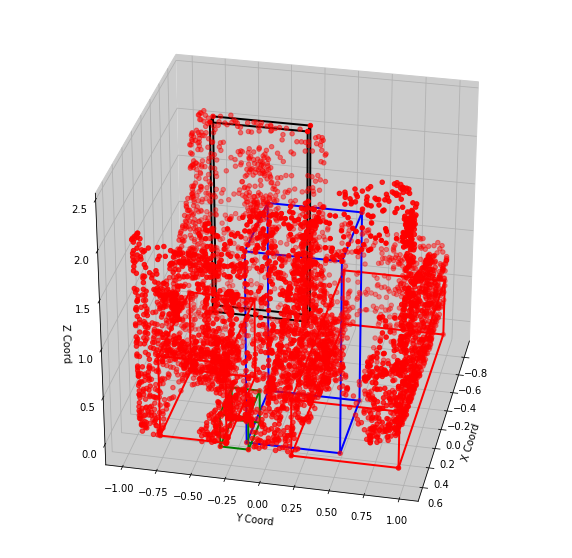

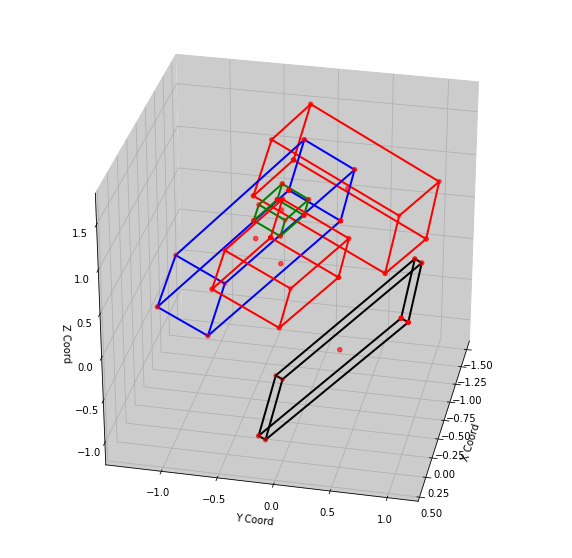

In [39]:
vertices = get_box_vertices(box_points)
draw_boxes(vertices, ply_file,axis_alignfile)
axis_alignment_matrix = get_axismatrix(axis_alignfile)

img_file = poses[2]
# camera pose file
camera_pose=np.loadtxt(os.path.join(path,img_file))

# axis align the camera pose
camera_pose = np.matmul(axis_alignment_matrix, camera_pose)
camera_pose = np.linalg.inv(camera_pose) # assuming camera to world

camera_coords=convert2camera_coords(vertices, camera_pose)
draw_boxes(camera_coords,name='camera.png')

In [40]:
box_points.shape

(5, 7)

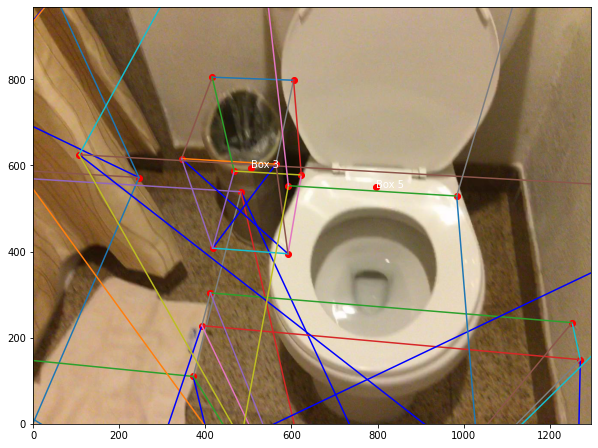

In [41]:
intrinsic_matrix=np.loadtxt(os.path.join(BASE_DIR,'intrinsic_color.txt'))
pixel_coords=convert2pixel_coords(camera_coords, intrinsic_matrix)
imgname=os.path.join(BASE_DIR, 'color', img_file[:-3]+'jpg')
draw_2dboxes(imgname, pixel_coords)

In [27]:
def write_angles_tofile(heading_angles, filepath, box_coordinates):
    box_coordinates[:,6] = heading_angles
    np.savetxt(filepath,box_coordinates)
    
filepath = os.path.join(BASE_DIR,'box_coords.txt')

# Annotate heading angles for scenes

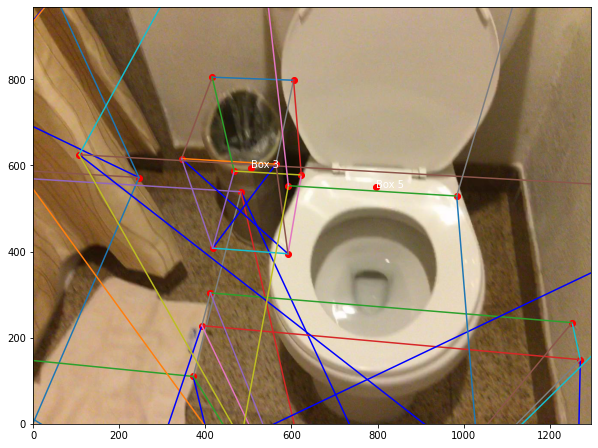

In [42]:
img_file = poses[2]
# camera pose file
camera_pose=np.loadtxt(os.path.join(path,img_file))
imgname=os.path.join(BASE_DIR, 'color', img_file[:-3]+'jpg')

# heading_angles = [0,0,0,0,0,0,0,0,0,0,0]
pix_coord = projection_to_rgb(box_points, intrinsic_matrix, camera_pose, axis_alignment_matrix)
draw_2dboxes(imgname, pix_coord)

In [16]:
# write_angles_tofile(heading_angles, filepath, box_points)

# Test Input Pipeline, Tensorflow Examples

In [155]:
image_paths = [os.path.join(BASE_DIR, 'color',i) for i in os.listdir(os.path.join(BASE_DIR, 'color'))[:3]]
depth_paths = [os.path.join(BASE_DIR, 'depth',i) for i in os.listdir(os.path.join(BASE_DIR, 'depth'))[:3]]
extrinsic_matrix_paths = [os.path.join(BASE_DIR, 'pose',i) for i in os.listdir(os.path.join(BASE_DIR, 'pose'))[:3]]
intrinsic_matrix_path = os.path.join(BASE_DIR,'intrinsic_color.txt')
axis_matrix_path = axis_alignfile
box_objects_path = filepath
filename = 'test.tfrecords'

In [150]:
save_to_tfrecords(image_paths, depth_paths, extrinsic_matrix_paths, intrinsic_matrix_path, axis_matrix_path, box_objects_path, filename)

In [6]:
tfrecord_dataset = tf.data.TFRecordDataset('test.tfrecords') # ['tfdata/scene0009_01.tfrecords','tfdata/scene0004_00.tfrecords']
parsed_dataset = tfrecord_dataset.map(read_decode_tfrecords)

In [23]:
for data in parsed_dataset.take(1):
    print(data['box_objects'].shape)

(11, 7)


In [2]:
# create input data
# write_data_to_tfrecords('train_data.txt')

/home/chidubem/deep-3d-reconstruction/projection_utils.py:197: RuntimeWarning: invalid value encountered in matmul
  pose = np.matmul(axis_alignment, extrinsic_matrix)
